In [1]:
from __future__ import print_function
import pydicom
from matplotlib import pyplot, cm
import os
import sys
import numpy as np
import pandas as pd
import scipy
from scipy import ndimage


In [2]:

def get_data(dicom_dir):
    #resize the image to desired resolution
    xsize = 256; ysize = 256
    
    data = np.zeros((xsize, ysize, 100))
    for i, s in enumerate(os.listdir(dicom_dir)):
    
        img = np.array(pydicom.read_file(dicom_dir+ s).pixel_array)
        xscale = xsize/img.shape[0]
        yscale = ysize/img.shape[1]
        data[:,:,i] = ndimage.interpolation.zoom(img, [xscale, yscale])
    #returning a numpy array of shape 100,256,256
    return data

In [3]:
X=get_data('./dicom_dir/')
X=np.moveaxis(X, -1, 0)

In [4]:
df=pd.read_csv('overview.csv',encoding='utf-8',sep=',')
del df['Unnamed: 0']
y=df.iloc[:,1].values
y= np.array([1 if yi else 0 for yi in y])
X.shape, y.shape

((100, 256, 256), (100,))

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test=train_test_split(X,y , test_size=0.1 , random_state=0)
## need to add a fake dimension in the end since keras image_generator expect 4 dim 
X_train=np.expand_dims(X_train, axis=3)
X_test=np.expand_dims(X_test,axis=3)
X=np.expand_dims(X,axis=3)
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((90, 256, 256, 1), (10, 256, 256, 1), (90,), (10,))

In [6]:
### using CONX 
import conx as cx

Using TensorFlow backend.
ConX, version 3.7.4


In [7]:
net = cx.Network("CTscan_CNN")

In [8]:
# some initial params
tile_size=(256,256)
base_depth = 32
### build the network
net.add(cx.ImageLayer("input", tile_size, 1))
c2 = lambda i, j, act = "relu": cx.Conv2DLayer("conv_{}".format(i, j), j, (3, 3), padding='same', activation=act)
net.add(c2(0, base_depth))
net.add(c2(1, base_depth))
net.add(cx.MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25))
net.add(c2(2, 2*base_depth))
net.add(c2(3, 2*base_depth))
net.add(cx.MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25))
net.add(cx.FlattenLayer('flat_input'))
net.add(cx.Layer('hidden1', 128, activation='relu'))
net.add(cx.Layer('output', 1, activation='sigmoid'))

'output'

In [10]:
#### making connection
net.connect('input', 'conv_0')
net.connect('conv_0', 'conv_1')
net.connect('conv_1', 'pool1')
net.connect('pool1', 'conv_2')
net.connect('conv_2', 'conv_3')
net.connect('conv_3', 'pool2')
net.connect('pool2', 'flat_input')
net.connect('flat_input', 'hidden1')
net.connect('hidden1', 'output')

In [11]:
### compile the network
net.compile(error="binary_crossentropy", optimizer="adam")

         but not using the 'softmax' activation function on layer 'output'


In [12]:
X_train[0].shape

(256, 256, 1)

<IPython.core.display.Javascript object>


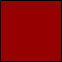
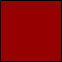
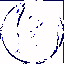
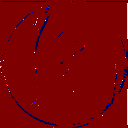
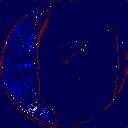
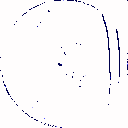
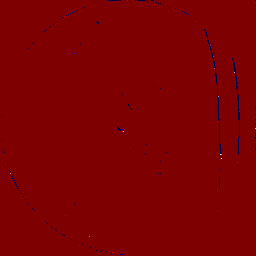
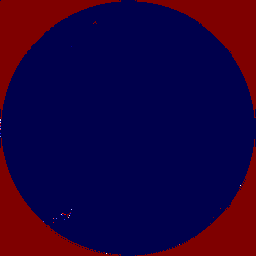
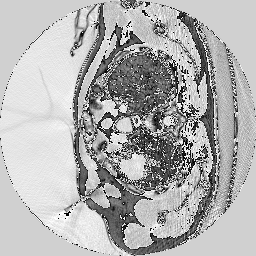

In [13]:
net.picture(X_train[0], dynamic = True, rotate = True, show_targets = True, scale = 1.25)

In [20]:
ip_pairs=[(a,b.reshape(1)) for a,b in zip(X_train,y_train)]
ip_pairs[0][0].shape, ip_pairs[0][1], X_train.shape

((256, 256, 1), array([0]), (90, 256, 256, 1))

In [21]:
net.dataset.clear()

net.dataset.append(ip_pairs)
net.dataset.split(0.2)

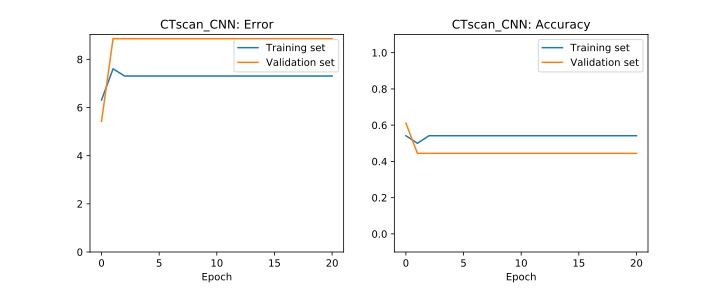

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   20 |   7.30693 |   0.54167 |   8.85688 |   0.44444 


In [22]:
net.train(epochs=20, record=True)

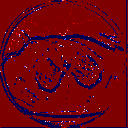

In [24]:
net.propagate_to_image("conv_3", X_train[0])


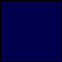
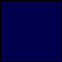
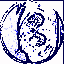
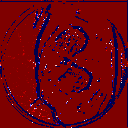
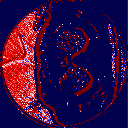
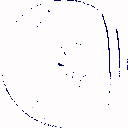
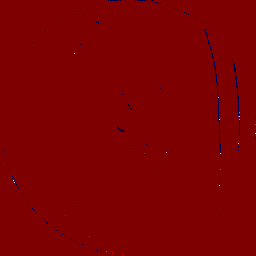
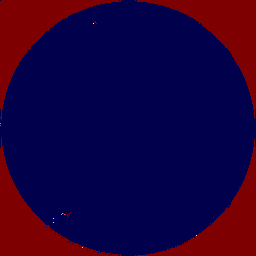
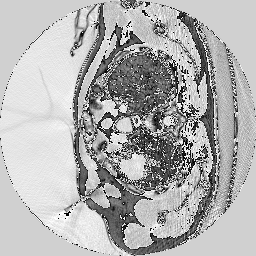

In [25]:
net.picture(X_train[0], dynamic = True, rotate = True, show_targets = True, scale = 1.25)

In [34]:
net.movie(lambda net, epoch: net.propagate_to_image("conv_1", X_train[0], scale = 3), 
                'mid_conv.gif', mp4 = False)

In [33]:
net.movie(lambda net, epoch: net.propagate_to_image("pool2", X_train[0], scale = 3), 
                'hr_conv.gif', mp4 = False)

In [31]:
#net.movie(lambda net, epoch: net.propagate_to_image("output", X_train[0], scale = 3), 'output.gif', mp4 = False)